In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,
                             roc_auc_score,
                             confusion_matrix,
                             classification_report,
                             make_scorer)
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     KFold,
                                     StratifiedKFold,
                                     learning_curve,
                                     validation_curve,
                                     GridSearchCV,
                                     RandomizedSearchCV)

import utils

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_csv('data/parole.csv', low_memory=False)
data.head()

,male,race,age,state,time.served,max.sentence,multiple.offenses,crime,violator
0,1,1,33.2,1,5.5,18,0,4,0
1,0,1,39.7,1,5.4,12,0,3,0
2,1,2,29.5,1,5.6,12,0,3,0
3,1,1,22.4,1,5.7,18,0,1,0
4,1,2,21.6,1,5.4,12,0,1,0


In [4]:
# Convert to numpy
X, y = data.values[:, :-1], data.values[:, -1].astype('int')
print(f'Shape : {X.shape}, {y.shape}')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)
print(f'Training : {X_train.shape}')
print(f'Test : {X_test.shape}')

Shape : (675, 8), (675,)
Training : (472, 8)
Test : (203, 8)


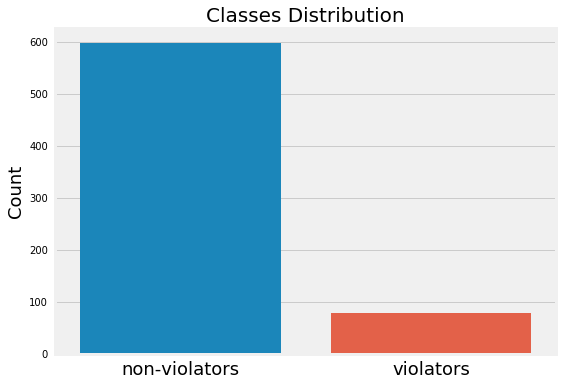

In [5]:
# Plot class distribution
utils.plot_class_dist(y, ['non-violators', 'violators'])

In [6]:
pca = PCA(n_components=None, svd_solver="full")
pca.fit(StandardScaler().fit_transform(X_train))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

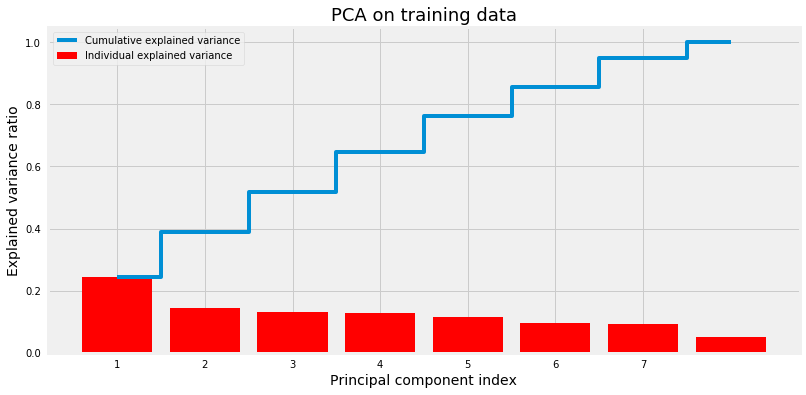

In [7]:
utils.plot_pca_var_explained(pca)

In [8]:
# Create dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
print(f'Training accuracy : {accuracy_score(y_train, dummy_clf.predict(X_train)):.2%}')
print(f'Training AUC : {roc_auc_score(y_train, dummy_clf.predict(X_train)):.2%}')

Training accuracy : 88.35%
Training AUC : 50.00%


In [9]:
# Create CV objest
kf = StratifiedKFold(5, shuffle=True, random_state=1)

In [10]:
rf_clf = RandomForestClassifier(100, class_weight='balanced')
cv_auc = cross_val_score(rf_clf, X_train, y_train,
                         scoring='roc_auc', n_jobs=-1, cv=kf)
print(f'10-fold cv AUC : {cv_auc.mean():.2f}')

10-fold cv AUC : 0.84


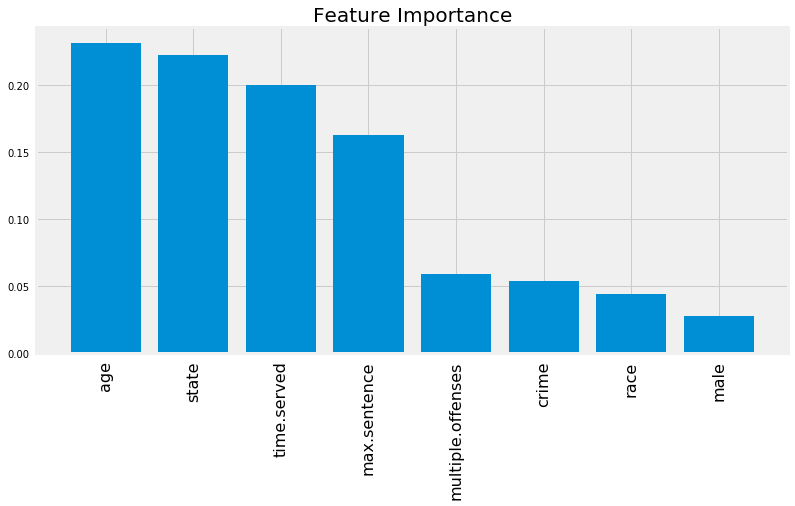

In [11]:
rf_clf.fit(X_train, y_train)
utils.plot_feature_imp(rf_clf, data.columns[:-1])

In [12]:
rf_clf = make_pipeline(StandardScaler(),
                       RandomForestClassifier(100, class_weight='balanced'))
cv_auc = cross_val_score(rf_clf, X_train, y_train,
                         scoring='roc_auc', n_jobs=-1, cv=kf)
print(f'10-fold cv AUC : {cv_auc.mean():.2f}')

10-fold cv AUC : 0.84


In [13]:
rf_clf.fit(X_train, y_train)
rf_clf.named_steps['randomforestclassifier'].feature_importances_

array([0.02717569, 0.03919286, 0.24753854, 0.19439852, 0.21425329,
       0.15975601, 0.06307867, 0.05460642])

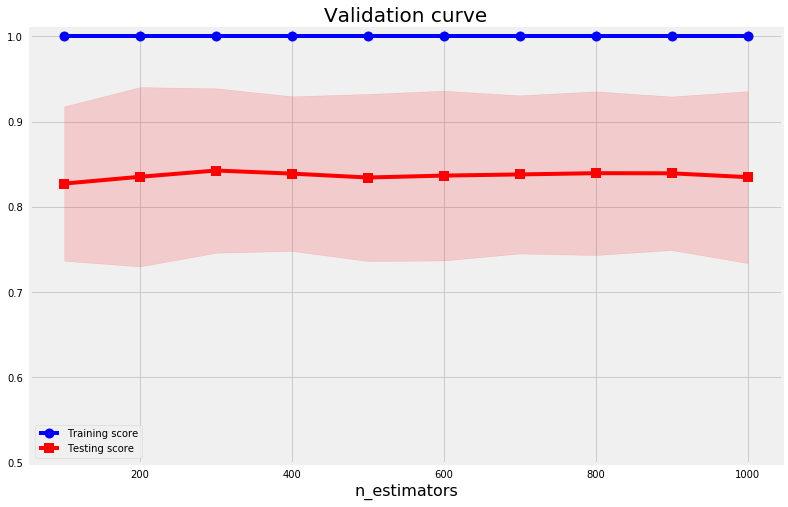

In [14]:
rf_clf = make_pipeline(StandardScaler(),
                       RandomForestClassifier(class_weight='balanced'))
param_range = np.linspace(100, 1000, 10, dtype='int')
train_scores, test_scores = validation_curve(rf_clf,
                                             X_train, y_train,
                                             param_name='randomforestclassifier__n_estimators',
                                             param_range=param_range,
                                             cv=10,
                                             scoring='roc_auc',
                                             n_jobs=-1)

utils.plot_validation_curve(train_scores, test_scores, param_range, y_lim=[0.5, 1.01],
                            x_label='n_estimators', title='Validation curve')

In [ ]:
# Defining custom-scoring function to be used in CV
def acc(y, y_pred):
    return (y == y_pred).mean()
scorer = make_scorer(acc)

rf_clf = RandomForestClassifier(100, class_weight='balanced')
cv_acc = cross_val_score(rf_clf, X_train, y_train,
                         scoring=scorer, n_jobs=-1, cv=kf)
print(f'10-fold cv accuracy : {cv_acc.mean():.2f}')

In [14]:
hyperparam = {
    'randomforestclassifier__n_estimators': np.linspace(100, 1000, 10, dtype='int'),
    'randomforestclassifier__max_features': ['sqrt', 'log2', 0.5],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__min_samples_leaf': [1, 3, 5]
}

rf_clf = GridSearchCV(make_pipeline(StandardScaler(),
                                    RandomForestClassifier(class_weight='balanced')),
                      param_grid=hyperparam,
                      scoring='roc_auc',
                      cv=kf,
                      n_jobs=-1)

In [ ]:
cv_auc = cross_val_score(rf_clf, X_train, y_train,
                         scoring='roc_auc', n_jobs=-1, cv=kf)
print(f'10-fold cv accuracy : {cv_auc.mean():.2f}')

In [18]:
clf = Pipeline([('sc', StandardScaler()), ('clf', RandomForestClassifier())])
hyperparam = [
    {'clf': [RandomForestClassifier(100)],
    'clf__max_features': ['sqrt', 'log2', 0.5],
    },
    {
    'clf': [LogisticRegression()],
    'clf__C': np.logspace(-4, 4, 10),
    'clf__penalty': ['l1', 'l2']
    }
]

rf_clf = GridSearchCV(clf,
                      param_grid=hyperparam,
                      scoring='roc_auc',
                      cv=kf,
                      n_jobs=-1)

In [19]:
rf_clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
         ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'clf': [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_...   2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]), 'clf__penalty': ['l1',

In [20]:
rf_clf.best_estimator_

Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
         ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [21]:
rf_clf.best_estimator_.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('clf',
   RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='log2', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
               oob_score=False, random_state=None, verbose=0,
               warm_start=False))],
 'sc': StandardScaler(copy=True, with_mean=True, with_std=True),
 'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
             oob_score=False, random_sta

In [26]:
x = np.random.normal(size=(5, 5))
x

array([[-0.36653134,  0.49311905,  0.06914584,  1.03600422, -0.73025373],
       [ 1.38867885, -1.78917353,  1.32044728, -1.01417168,  0.77943313],
       [-0.73592617, -1.02106407, -1.35423687, -0.58545064, -0.28683168],
       [ 2.07064918,  1.08871804, -2.33771996, -0.50906426, -0.43974994],
       [-1.81002852,  0.27959689, -0.04235904,  0.6644657 ,  0.27479028]])

In [32]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

In [33]:
df.to_csv('newsgroups.csv')

In [34]:
df

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc
10000,From: a207706@moe.dseg.ti.com (Robert Loper)\n...,7,rec.autos
10001,From: kimman@magnus.acs.ohio-state.edu (Kim Ri...,6,misc.forsale
10002,From: kwilson@casbah.acns.nwu.edu (Kirtley Wil...,2,comp.os.ms-windows.misc
10003,Subject: Re: Don't more innocents die without ...,0,alt.atheism
10004,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,0,alt.atheism


In [37]:
pca = make_pipeline(StandardScaler(), PCA(2))
X_pca = pca.fit_transform(X_train, y_train)

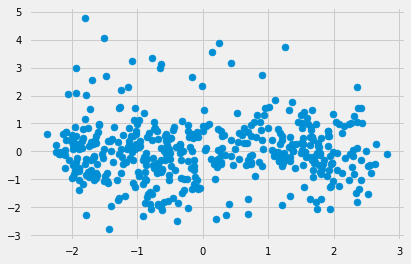

In [42]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])

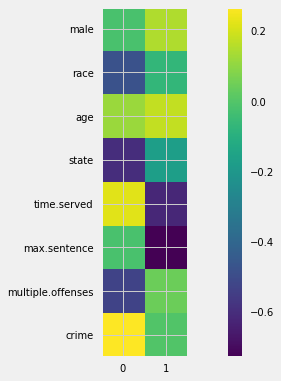

In [57]:
plt.figure(figsize=(12, 6))
plt.imshow(pca.named_steps['pca'].components_.T)
plt.yticks(range(8), data.columns[:-1])
plt.colorbar();

In [53]:
num_param_combinations = 20
n_estimators = np.random.choice(
    list(range(50, 1001, 50)), size=num_param_combinations)
min_impurity_decrease = np.random.exponential(
    scale=0.01, size=num_param_combinations)
max_features = np.random.choice(list(np.arange(
    0.01, 1., 0.01)), size=num_param_combinations)
criterion = np.random.choice(
    ['gini', 'entropy'], size=num_param_combinations)
max_depth = np.random.choice(
    list(range(1, 51)) + [None], size=num_param_combinations)

hyperparam_space = {
    'randomforestclassifier__n_estimators': n_estimators,
    'randomforestclassifier__min_impurity_decrease': min_impurity_decrease,
    'randomforestclassifier__max_features': max_features,
    'randomforestclassifier__criterion': criterion,
    'randomforestclassifier__max_depth': max_depth,
    }

rf_pipeline = make_pipeline(RobustScaler(),
                            RandomForestClassifier(class_weight='balanced',
                                                   random_state=123)
                           )

rf_clf = RandomizedSearchCV(rf_pipeline,
                            param_distributions=hyperparam_space,
                            n_iter=10,
                            scoring='roc_auc',
                            n_jobs=-1,
                            cv=kf, )

rf_clf.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_...timators=10, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'randomforestclassifier__n_estimators': array([ 750,  650,  250,  400,  100,  700,  200,  550,  950,  400,  600,
        250,  750,  500, 1000,  150,  100,  850,  700,  400]), 'randomforestclassifier__min_impurity_decrease': array([0.03928, 0.00143, 0.00115, 0.00176, 0.00028, 0....[18, 27, 22, 22, 16, 41, 21, 40, 15, 39, 2, 25, 18, 8, 23, 3, 1

In [65]:
rf_clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_randomforestclassifier__n_estimators', 'param_randomforestclassifier__min_impurity_decrease', 'param_randomforestclassifier__max_features', 'param_randomforestclassifier__max_depth', 'param_randomforestclassifier__criterion', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [87]:
utils.report_search_cv(rf_clf.cv_results_)

Model rank 1
------------
Mean validation score: 0.853 (std: 0.070)
Parameters: {'randomforestclassifier__n_estimators': 400, 'randomforestclassifier__min_impurity_decrease': 0.017487904797311028, 'randomforestclassifier__max_features': 0.6, 'randomforestclassifier__max_depth': 21, 'randomforestclassifier__criterion': 'entropy'}

Model rank 2
------------
Mean validation score: 0.852 (std: 0.073)
Parameters: {'randomforestclassifier__n_estimators': 500, 'randomforestclassifier__min_impurity_decrease': 0.005737325744106, 'randomforestclassifier__max_features': 0.59, 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__criterion': 'entropy'}

Model rank 3
------------
Mean validation score: 0.842 (std: 0.075)
Parameters: {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_impurity_decrease': 0.004047562614227455, 'randomforestclassifier__max_features': 0.32, 'randomforestclassifier__max_depth': 22, 'randomforestclassifier__criterion': 'gini'}

